![for sale image, from https://time.com/5835778/selling-home-coronavirus/](https://api.time.com/wp-content/uploads/2020/05/selling-home-coronavirus.jpg?w=800&quality=85)

# Project Title

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

Questions to consider:

- Who are your stakeholders?
- What are your stakeholders' pain points related to this project?
- Why are your predictions important from a business perspective?

## Data Understanding

Describe the data being used for this project.

Questions to consider:

- Where did the data come from, and how do they relate to the data analysis questions?
- What do the data represent? Who is in the sample and what variables are included?
- What is the target variable?
- What are the properties of the variables you intend to use?

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

%matplotlib inline

In [2]:
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
df.info()
# What's the difference btwn sqft_living15/sqft_lot15 and sqft_living/sqft_lot?
# Target variable is price
# Waterfront column is only one with non-null, need to clean that up (assume that null = no waterfront)
# Categorical columns: waterfront, view, condition, grade
# sqft_basement is object, need to convert to numerical format
# for GIS analysis need to find CSR for lat/long

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
df.describe()
# Looks like there are some extreme outliers in the sqft_lot/sqft_living/bathrooms/bedrooms columns, I am assuming an outlier in one of those columns  means that we'll see similar outliers in the others
# Wonder what .5 floors counts as?
# Looking at yr_built and yr_renovated it looks like the later has a log of properties that have no record of renovation
# Do we want to make a "yr_sold" column just to make comparison btween those variables easier (**FEATURE ENGINEERING!!!**)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


## Data Preparation

Describe and justify the process for preparing the data for analysis.

Questions to consider:

- Were there variables you dropped or created?
- How did you address missing values or outliers?
- Why are these choices appropriate given the data and the business problem?

## Bedrooms

In [5]:
# dropping any larger then five, presumption being >5 not single family
df = df[df['bedrooms']<6]
df['bedrooms'].value_counts().sort_index()

1     196
2    2760
3    9824
4    6882
5    1601
Name: bedrooms, dtype: int64

## Bathrooms

In [6]:
# clearing out bathrooms over 4 and less than 1 - given distribution these are outliers 
df = df[(df['bathrooms']<=4) & (df['bathrooms']>=1)]
df['bathrooms'].value_counts().sort_index()

1.00    3844
1.25       9
1.50    1437
1.75    3031
2.00    1905
2.25    2029
2.50    5345
2.75    1148
3.00     699
3.25     575
3.50     708
3.75     139
4.00     117
Name: bathrooms, dtype: int64

## Waterfront

In [7]:
# SO few houses meet this criteria it is immaterial
df = df.drop(columns = 'waterfront')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20986 entries, 0 to 21595
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20986 non-null  int64  
 1   date           20986 non-null  object 
 2   price          20986 non-null  float64
 3   bedrooms       20986 non-null  int64  
 4   bathrooms      20986 non-null  float64
 5   sqft_living    20986 non-null  int64  
 6   sqft_lot       20986 non-null  int64  
 7   floors         20986 non-null  float64
 8   view           20927 non-null  object 
 9   condition      20986 non-null  object 
 10  grade          20986 non-null  object 
 11  sqft_above     20986 non-null  int64  
 12  sqft_basement  20986 non-null  object 
 13  yr_built       20986 non-null  int64  
 14  yr_renovated   17247 non-null  float64
 15  zipcode        20986 non-null  int64  
 16  lat            20986 non-null  float64
 17  long           20986 non-null  float64
 18  sqft_l

## View

In [8]:
# Given distribution we decided this was worth keeping, but we decided to bin the results as 1 = view, 0 = no view
df['view_y_n'] = df['view'].map(lambda x: 0 if x =='NONE' else 1)
df = df.drop(columns = 'view')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20986 entries, 0 to 21595
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20986 non-null  int64  
 1   date           20986 non-null  object 
 2   price          20986 non-null  float64
 3   bedrooms       20986 non-null  int64  
 4   bathrooms      20986 non-null  float64
 5   sqft_living    20986 non-null  int64  
 6   sqft_lot       20986 non-null  int64  
 7   floors         20986 non-null  float64
 8   condition      20986 non-null  object 
 9   grade          20986 non-null  object 
 10  sqft_above     20986 non-null  int64  
 11  sqft_basement  20986 non-null  object 
 12  yr_built       20986 non-null  int64  
 13  yr_renovated   17247 non-null  float64
 14  zipcode        20986 non-null  int64  
 15  lat            20986 non-null  float64
 16  long           20986 non-null  float64
 17  sqft_living15  20986 non-null  int64  
 18  sqft_l

## Grade

- Removing Luxury and Mansion lines as definition unclear compared to other grades. 
- Removing Low as only 14 houses meet criteria. 
- Keeping single family house in mind as what this table represents.

In [9]:
df = df[(df['grade'] != '13 Mansion') & (df['grade'] != '12 Luxury') & (df['grade'] != '4 Low')]
df['grade'].value_counts()

7 Average        8829
8 Good           5947
9 Better         2556
6 Low Average    2002
10 Very Good     1043
11 Excellent      310
5 Fair            224
Name: grade, dtype: int64

## Year Renovated

In [10]:
# Filling in missing values in this column
df['yr_renovated'] = df['yr_renovated'].fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20911 entries, 0 to 21595
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20911 non-null  int64  
 1   date           20911 non-null  object 
 2   price          20911 non-null  float64
 3   bedrooms       20911 non-null  int64  
 4   bathrooms      20911 non-null  float64
 5   sqft_living    20911 non-null  int64  
 6   sqft_lot       20911 non-null  int64  
 7   floors         20911 non-null  float64
 8   condition      20911 non-null  object 
 9   grade          20911 non-null  object 
 10  sqft_above     20911 non-null  int64  
 11  sqft_basement  20911 non-null  object 
 12  yr_built       20911 non-null  int64  
 13  yr_renovated   20911 non-null  float64
 14  zipcode        20911 non-null  int64  
 15  lat            20911 non-null  float64
 16  long           20911 non-null  float64
 17  sqft_living15  20911 non-null  int64  
 18  sqft_l

## Square Footage of the Basement

In [11]:
# Cleaning up the weird '?' values in this column
df['sqft_basement'] = df['sqft_basement'].map(lambda x: 0 if x == '?' else x)
df['sqft_basement'] = pd.to_numeric(df['sqft_basement'])
df['sqft_basement'].value_counts()

0.0       12982
600.0       208
500.0       206
700.0       202
800.0       192
          ...  
243.0         1
1930.0        1
283.0         1
588.0         1
2220.0        1
Name: sqft_basement, Length: 277, dtype: int64

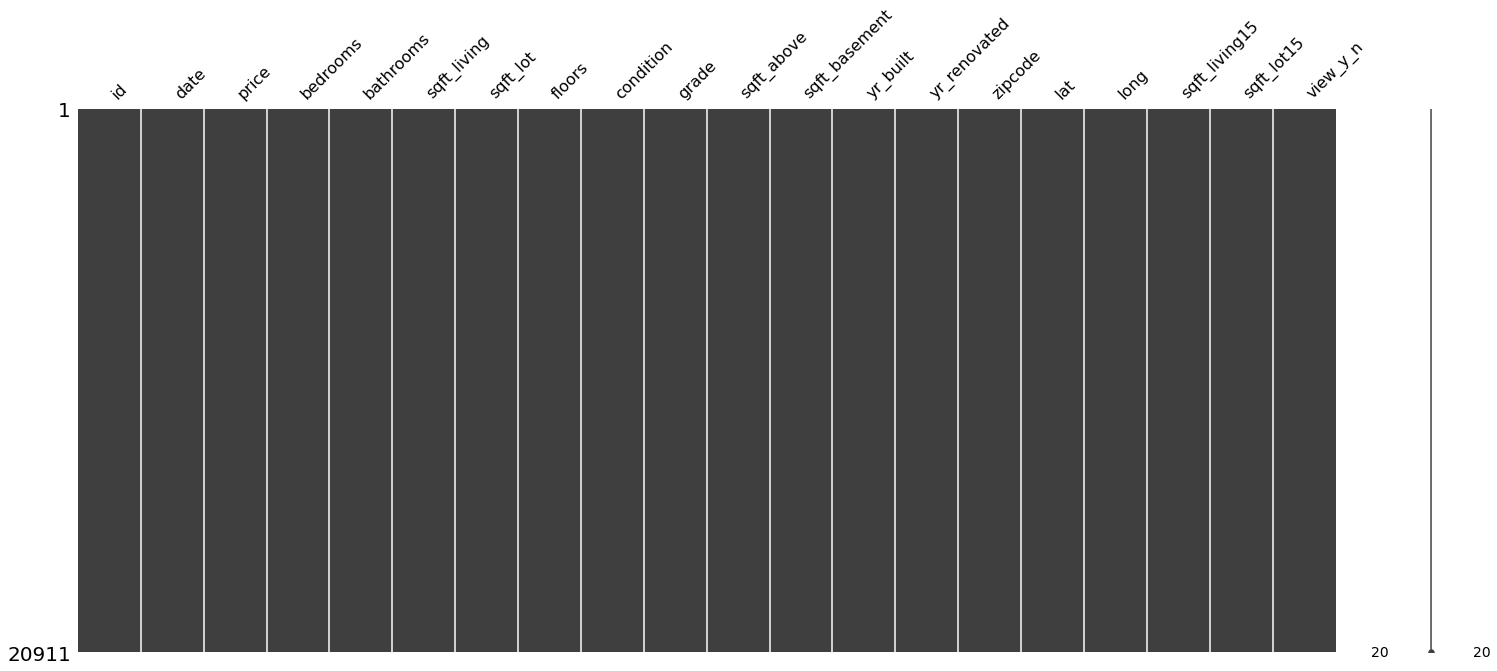

In [12]:
# Including this matrix to visually demonstrate that we have cleaned and dealt with missing values throughout
# the dataframe.
import missingno as msno
msno.matrix(df);

## ADD GIS DATA

- Only one team member had the appropriate libraries installed. For more detailed information, look at **"INSERT NOTEBOOK NAME HERE"**

In [13]:
# This df includes all of the above cleaning PLUS the geodata from notebook cited above.
geo_df = pd.read_csv('data/kc_house_data_with_GIS_V2.csv', index_col = 0)

# Adding a Total Distance column for each house
geo_df['total_dist'] = geo_df['police_dist']+geo_df['medical_dist']+geo_df['school_dist']+geo_df['farmers_dist']

## Dropping columns and filtering price

In [14]:
# Dropping Names of Police Stations, Schools, Hospitals, and Farmers Markets
geo_df = geo_df.drop(['geometry', 'police_name', 'school_name', 'medical_name', 'farmers_name'], axis = 1)
geo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20911 entries, 0 to 20910
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20911 non-null  int64  
 1   date           20911 non-null  object 
 2   price          20911 non-null  float64
 3   bedrooms       20911 non-null  int64  
 4   bathrooms      20911 non-null  float64
 5   sqft_living    20911 non-null  int64  
 6   sqft_lot       20911 non-null  int64  
 7   floors         20911 non-null  float64
 8   condition      20911 non-null  object 
 9   grade          20911 non-null  object 
 10  sqft_above     20911 non-null  int64  
 11  sqft_basement  20911 non-null  float64
 12  yr_built       20911 non-null  int64  
 13  yr_renovated   20911 non-null  float64
 14  zipcode        20911 non-null  int64  
 15  lat            20911 non-null  float64
 16  long           20911 non-null  float64
 17  sqft_living15  20911 non-null  int64  
 18  sqft_l

In [15]:
# Dropping other columns we know we won't use later.
geo_df = geo_df.drop(['date', 'zipcode', 'yr_built', 'yr_renovated', 'lat', 'long'], axis = 1)
geo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20911 entries, 0 to 20910
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20911 non-null  int64  
 1   price          20911 non-null  float64
 2   bedrooms       20911 non-null  int64  
 3   bathrooms      20911 non-null  float64
 4   sqft_living    20911 non-null  int64  
 5   sqft_lot       20911 non-null  int64  
 6   floors         20911 non-null  float64
 7   condition      20911 non-null  object 
 8   grade          20911 non-null  object 
 9   sqft_above     20911 non-null  int64  
 10  sqft_basement  20911 non-null  float64
 11  sqft_living15  20911 non-null  int64  
 12  sqft_lot15     20911 non-null  int64  
 13  view_y_n       20911 non-null  int64  
 14  police_dist    20911 non-null  float64
 15  school_dist    20911 non-null  float64
 16  medical_dist   20911 non-null  float64
 17  farmers_dist   20911 non-null  float64
 18  total_

In [16]:
# Removing price outliers based on our business understanding.
# According to Zillow, mean sale price for houses in King County is $798,135.
# Setting the max as $1 million to give some wiggle room above the given mean.
geo_df = geo_df[geo_df['price'] < 1000000]
geo_df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_living15,sqft_lot15,view_y_n,police_dist,school_dist,medical_dist,farmers_dist,total_dist
count,1.970000e+04,19700.000000,19700.000000,19700.000000,19700.000000,1.970000e+04,19700.000000,19700.000000,19700.000000,19700.000000,19700.000000,19700.000000,19700.000000,19700.000000,19700.000000,19700.000000,19700.000000
mean,4.615817e+09,465573.584975,3.284416,2.025419,1939.579086,1.444756e+04,1.470533,1682.896193,251.410102,1905.112589,12332.173452,0.074264,0.030854,0.008618,0.030626,0.034400,0.104499
std,2.880613e+09,194046.324777,0.808020,0.674402,733.469744,4.013297e+04,0.536861,697.212879,393.684471,597.133485,26382.699337,0.262207,0.020532,0.008514,0.032052,0.024983,0.066268
min,1.200019e+06,78000.000000,1.000000,1.000000,390.000000,5.200000e+02,1.000000,390.000000,0.000000,399.000000,651.000000,0.000000,0.000513,0.000095,0.000391,0.000799,0.013083
25%,2.141328e+09,313000.000000,3.000000,1.500000,1390.000000,5.000000e+03,1.000000,1170.000000,0.000000,1460.000000,5040.000000,0.000000,0.017367,0.004319,0.013692,0.017947,0.066166
50%,3.918400e+09,431350.000000,3.000000,2.000000,1830.000000,7.500000e+03,1.000000,1500.000000,0.000000,1790.000000,7519.000000,0.000000,0.026877,0.006700,0.022184,0.029222,0.089807
75%,7.350101e+09,589500.000000,4.000000,2.500000,2390.000000,1.020225e+04,2.000000,2060.000000,490.000000,2250.000000,9800.000000,0.000000,0.039266,0.010122,0.036513,0.045483,0.120115
max,9.900000e+09,999999.000000,5.000000,4.000000,6050.000000,1.651359e+06,3.500000,5450.000000,2720.000000,4950.000000,871200.000000,1.000000,0.339291,0.325079,0.604612,0.519270,1.407284


## One Hot Encoding & Train/Test Split

In [17]:
# Setting up x to include all columns except for price
# Setting up y to be price as our dependent variable
X = geo_df.drop(columns = ['id', 'price'])
y = geo_df['price']

# One Hot Encoder will need this later so we're setting it up now
cat_cols= ['grade', 'condition']

In [18]:
# Setting up train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y,  test_size=0.3, random_state=42)

In [19]:
# Settning up OneHotEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore') 
X_train_ohe = ohe.fit_transform(X_train[cat_cols])

In [20]:
# Setting up a full data frame for visualizations we will use later in the notebook
X_train_ohe_data = pd.DataFrame(X_train_ohe, columns= ohe.get_feature_names(cat_cols), index = X_train.index)
X_train_full = pd.concat([X_train.drop(cat_cols, axis=1), X_train_ohe_data], axis = 1)
X_train_full

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_living15,sqft_lot15,view_y_n,...,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,condition_Average,condition_Fair,condition_Good,condition_Poor,condition_Very Good
8356,3,1.00,1180,7068,1.0,1180,0.0,1180,7068,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11642,3,1.75,2010,4905,1.0,1230,780.0,2210,1834,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20619,3,3.25,1300,1325,2.0,1080,220.0,1290,1323,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
20126,4,1.50,1500,2106,2.0,1500,0.0,1490,2175,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5704,3,2.00,2168,4000,1.5,2168,0.0,1770,4000,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11956,3,1.50,910,5120,1.0,910,0.0,1410,5132,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12658,3,2.00,1680,8487,1.0,1680,0.0,2080,8560,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5708,4,3.00,3090,35074,2.0,3090,0.0,3120,35150,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
908,3,2.25,1580,47916,1.0,1580,0.0,1980,75358,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [21]:
# Doing the same code but for the X test set
X_test_ohe = ohe.transform(X_test[cat_cols])
X_test_ohe_data = pd.DataFrame(X_test_ohe, columns= ohe.get_feature_names(cat_cols), index = X_test.index)
X_test_full = pd.concat([X_test.drop(cat_cols, axis=1), X_test_ohe_data], axis = 1)
X_test_full

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_living15,sqft_lot15,view_y_n,...,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,condition_Average,condition_Fair,condition_Good,condition_Poor,condition_Very Good
12014,4,2.50,2810,7549,2.0,2810,0.0,2750,7642,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
17699,2,1.00,960,112384,1.0,960,0.0,1210,24875,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
18671,3,2.50,2200,5954,2.0,2200,0.0,2200,5046,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
16367,3,1.75,1480,383328,1.5,1480,0.0,1480,67082,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1823,4,2.75,2020,2750,1.0,1010,1010.0,1840,4000,0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15059,4,2.25,1890,4300,1.5,1350,540.0,1830,3800,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11443,4,2.25,1930,8925,1.0,1930,0.0,1930,8400,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6061,3,2.50,2280,12746,1.0,1490,790.0,2100,12746,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
10859,4,2.50,3040,20682,2.0,3040,0.0,2670,9742,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [22]:
# Fixing column names to make our lives easier later.
X_train_full.columns = X_train_full.columns.str.replace(' ', '')
X_test_full.columns = X_test_full.columns.str.replace(' ', '')

In [23]:
# We will need to make visualizations of this data later, so we are going to combine X train and Y train
# after using the OHE.
X_y_train_full = pd.concat([X_train_full, y_train], axis = 1)

## Modeling

Describe and justify the process for analyzing or modeling the data.

Questions to consider:

- How did you analyze the data to arrive at an initial approach?
- How did you iterate on your initial approach to make it better?
- Why are these choices appropriate given the data and the business problem?

## Evaluation

The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem. 

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
- How well does your model/data fit any modeling assumptions?

For the final model, you might also consider:

- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?

### Baseline Understanding

- What does a baseline, model-less prediction look like?

In [24]:
# code here to arrive at a baseline prediction

### First $&(@# Model

Before going too far down the data preparation rabbit hole, be sure to check your work against a first 'substandard' model! What is the easiest way for you to find out how hard your problem is?

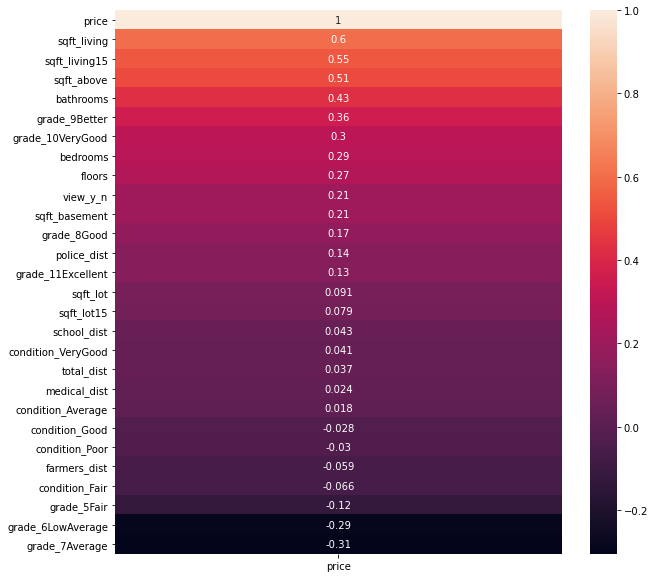

In [25]:
# Looking at correlations between price and other features.
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(X_y_train_full.corr()[['price']].sort_values(by = ['price'], ascending = False), annot=True);

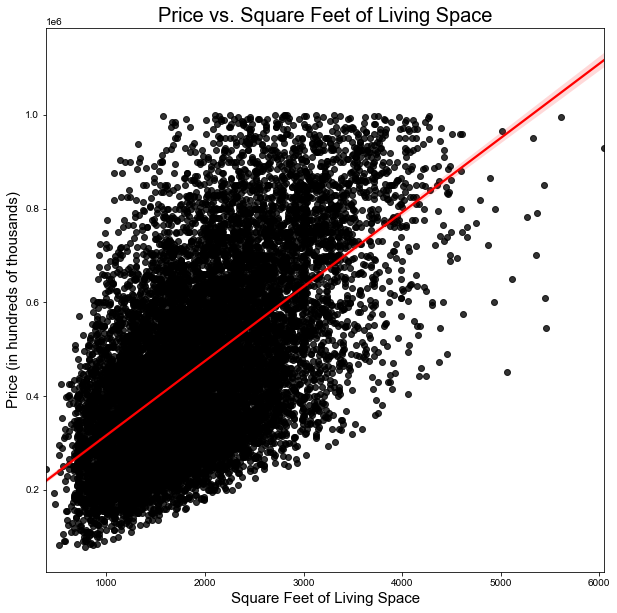

In [26]:
# sqft_living looks like the strongest positive correlation.

fig, ax = plt.subplots(figsize = (10,10))
ax = sns.regplot(x="sqft_living", y="price", data= X_y_train_full, scatter_kws={"color": "black"}, line_kws={"color": "red"})

plt.title('Price vs. Square Feet of Living Space', fontsize=20)
plt.xlabel('Square Feet of Living Space', fontsize=15)
plt.ylabel('Price (in hundreds of thousands)', fontsize=15)
sns.set_style("whitegrid")

plt.show;

In [27]:
# Performing an OLS model on sqft_living
model1 = sm.OLS(y_train, sm.add_constant(X_train_full['sqft_living'])).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     7645.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        20:41:52   Log-Likelihood:            -1.8447e+05
No. Observations:               13790   AIC:                         3.689e+05
Df Residuals:                   13788   BIC:                         3.690e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.578e+05   3753.544     42.030      0.000     1.5e+05    1.65e+05
sqft_living   158.5361      1.813     87.438      0.000     154.982     162.090
==============================================================================
Omnibus:                      495.587   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              549.987
Skew:                           0.488   Prob(JB):                    3.73e-120
Kurtosis:                       2.935   Cond. No.                     5.85e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Testing Assumptions for our 'Simple' Model

In [28]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_full, y_train)
train_preds = lr.predict(X_train_full)
test_preds = lr.predict(X_test_full)

In [29]:
# Train is slightly underfit. Adding complexity should address this issue.
from sklearn.metrics import r2_score
print(f"Train R2: {r2_score(y_train, train_preds):.4f}")
print(f"Test R2: {r2_score(y_test, test_preds):.4f}")

Train R2: 0.5192
Test R2: 0.5293


### Modeling Iterations

Now you can start to use the results of your first model to iterate - there are many options!

We will begin by using VIM to address issues related to multicollinearity:

In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# defining an empty dataframe to capture the VIF scores
vif = pd.DataFrame()

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score
vif["VIF"] = [variance_inflation_factor(X_train_full.values, i) for i in range(len(X_train_full.columns))]

# label the scores with their related columns
vif["features"] = X_train_full.columns

vif

# sqft_living has very, very high multicoliniarity - not necessarily an issue for the simple model since it's only the one
# variable, for the multiple model may be a concern

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF,features
0,1.726344,bedrooms
1,2.653490,bathrooms
2,110.154625,sqft_living
3,2.154942,sqft_lot
4,2.044833,floors
5,99.303230,sqft_above
6,30.828358,sqft_basement
7,2.743511,sqft_living15
8,2.413302,sqft_lot15
9,1.087484,view_y_n


In [31]:
#improve multicoliniarity of suspected correlated features by dropping said features from df - sqft_above, sqft_basement

X_train_full.drop(['sqft_above', 'sqft_basement'], axis=1, inplace=True)
X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13790 entries, 8356 to 16730
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bedrooms            13790 non-null  int64  
 1   bathrooms           13790 non-null  float64
 2   sqft_living         13790 non-null  int64  
 3   sqft_lot            13790 non-null  int64  
 4   floors              13790 non-null  float64
 5   sqft_living15       13790 non-null  int64  
 6   sqft_lot15          13790 non-null  int64  
 7   view_y_n            13790 non-null  int64  
 8   police_dist         13790 non-null  float64
 9   school_dist         13790 non-null  float64
 10  medical_dist        13790 non-null  float64
 11  farmers_dist        13790 non-null  float64
 12  total_dist          13790 non-null  float64
 13  grade_10VeryGood    13790 non-null  float64
 14  grade_11Excellent   13790 non-null  float64
 15  grade_5Fair         13790 non-null  float64
 16  g

In [32]:
# Dropping same columns in test set.

X_test_full.drop(['sqft_above', 'sqft_basement'], axis=1, inplace=True)
X_test_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5910 entries, 12014 to 6818
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bedrooms            5910 non-null   int64  
 1   bathrooms           5910 non-null   float64
 2   sqft_living         5910 non-null   int64  
 3   sqft_lot            5910 non-null   int64  
 4   floors              5910 non-null   float64
 5   sqft_living15       5910 non-null   int64  
 6   sqft_lot15          5910 non-null   int64  
 7   view_y_n            5910 non-null   int64  
 8   police_dist         5910 non-null   float64
 9   school_dist         5910 non-null   float64
 10  medical_dist        5910 non-null   float64
 11  farmers_dist        5910 non-null   float64
 12  total_dist          5910 non-null   float64
 13  grade_10VeryGood    5910 non-null   float64
 14  grade_11Excellent   5910 non-null   float64
 15  grade_5Fair         5910 non-null   float64
 16  gr

In [33]:
vif = pd.DataFrame()

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score
vif["VIF"] = [variance_inflation_factor(X_train_full.values, i) for i in range(len(X_train_full.columns))]

# label the scores with their related columns
vif["features"] = X_train_full.columns

vif

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF,features
0,1.721554,bedrooms
1,2.589833,bathrooms
2,4.146766,sqft_living
3,2.152591,sqft_lot
4,1.594946,floors
5,2.613486,sqft_living15
6,2.412483,sqft_lot15
7,1.065360,view_y_n
8,inf,police_dist
9,inf,school_dist


After dropping columns, our score for sqft_living improved to 4.146766, which is under the common threshhold of 5.0 for issues related to multicollinearity.

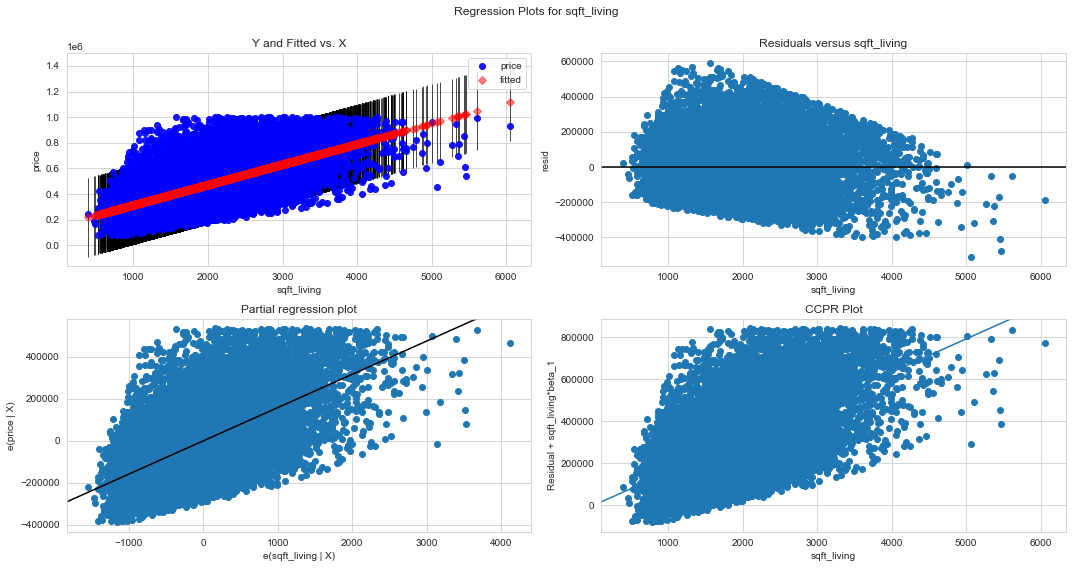

In [34]:
# Checking for variance and heteroskedacity. Saw similar issues with the scatter/regression plot above.
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model1, 'sqft_living', fig=fig)

<ipython-input-35-ae257fbed77b>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


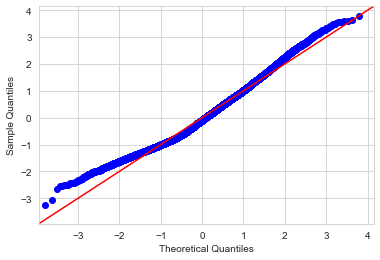

In [35]:
# Residuals do not appear to have any significant deviations, so the normalization for this model appears to be okay.
import scipy.stats as stats
residuals = model1.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line = '45', fit = 'True')
fig.show()

## Moving on to multiple linear regression models:

In [36]:
# Performing an OLS model on sqft_living and view_y_n.
model2 = sm.OLS(y_train, sm.add_constant(X_train_full[['sqft_living', 'view_y_n']])).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     4097.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        20:41:54   Log-Likelihood:            -1.8429e+05
No. Observations:               13790   AIC:                         3.686e+05
Df Residuals:                   13787   BIC:                         3.686e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.603e+05   3708.872     43.212      0.000    1.53e+05    1.68e+05
sqft_living   153.5871      1.810     84.871      0.000     150.040     157.134
view_y_n     9.494e+04   5050.350     18.799      0.000     8.5e+04    1.05e+05
==============================================================================
Omnibus:                      441.725   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              484.614
Skew:                           0.458   Prob(JB):                    5.85e-106
Kurtosis:                       2.935   Cond. No.                     7.97e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.97e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

After adding 'view_y_n' the r-squared score for our model improved from 0.357 to 0.373.

<ipython-input-37-77e65c192495>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


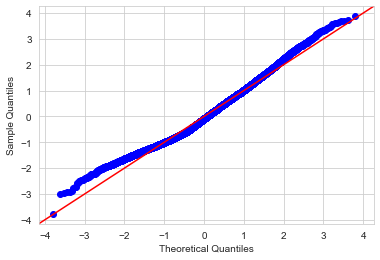

In [37]:
# Residuals do not appear to have any significant deviations, so the normalization for this model appears to be okay.
# Perhaps this is even better than our simple lr model.
import scipy.stats as stats
residuals = model2.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line = '45', fit = 'True')
fig.show()

In [38]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# train_preds2 = model2.predict(X_train_full[['sqft_living', 'view_y_n']])

# print(mean_squared_error(y_train, train_preds, squared=False))
# print(mean_squared_error(y_test, test_preds, squared=False))


In [39]:

# print("Metrics:")
# # R2
# print(f"R2: {r2_score(y_train, train_preds2):.3f}")
# # MAE
# print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds2):.3f}")
# # MSE
# print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds2):.3f}")
# # RMSE - just MSE but set squared=False
# print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds2, squared=False):.3f}")

In [40]:
# Performing an OLS model on sqft_living, view_y_n, and bedrooms.
# This model improves r-sqaured from 0.373 to 0.380
model3 = sm.OLS(y_train, sm.add_constant(X_train_full[['sqft_living', 'view_y_n', 'bedrooms']])).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     2812.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        20:41:55   Log-Likelihood:            -1.8422e+05
No. Observations:               13790   AIC:                         3.684e+05
Df Residuals:                   13786   BIC:                         3.685e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.101e+05   5476.858     38.367      0.000    1.99e+05    2.21e+05
sqft_living   170.4053      2.259     75.428      0.000     165.977     174.834
view_y_n     9.081e+04   5034.167     18.038      0.000    8.09e+04    1.01e+05
bedrooms    -2.502e+04   2031.567    -12.317      0.000    -2.9e+04    -2.1e+04
==============================================================================
Omnibus:                      459.984   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              507.196
Skew:                           0.470   Prob(JB):                    7.31e-111
Kurtosis:                       3.005   Cond. No.                     9.04e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<ipython-input-41-bf0e018bc906>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


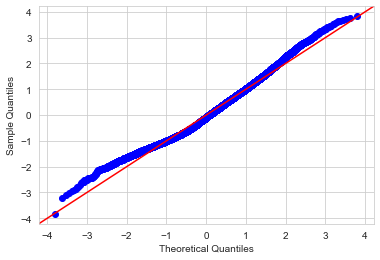

In [41]:
# Residuals do not appear to have any significant deviations, so the normalization for this model appears to be okay.
# Perhaps this is even better than our simple lr model.
import scipy.stats as stats
residuals = model3.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line = '45', fit = 'True')
fig.show()

In [42]:
# Performing an OLS model on sqft_living, view_y_n, bedrooms, and bathrooms.
# This model improves r-sqaured from 0.380 to 0.381
model4 = sm.OLS(y_train, sm.add_constant(X_train_full[['sqft_living', 'view_y_n', 'bedrooms', 'bathrooms']])).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     2119.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        20:41:55   Log-Likelihood:            -1.8420e+05
No. Observations:               13790   AIC:                         3.684e+05
Df Residuals:                   13785   BIC:                         3.685e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.017e+05   5710.939     35.319      0.000    1.91e+05    2.13e+05
sqft_living   162.1602      2.767     58.612      0.000     156.737     167.583
view_y_n     9.177e+04   5033.011     18.234      0.000    8.19e+04    1.02e+05
bedrooms    -2.626e+04   2043.926    -12.850      0.000   -3.03e+04   -2.23e+04
bathrooms    1.403e+04   2721.926      5.153      0.000    8691.306    1.94e+04
==============================================================================
Omnibus:                      479.687   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              531.104
Skew:                           0.481   Prob(JB):                    4.70e-116
Kurtosis:                       3.015   Cond. No.                     9.44e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<ipython-input-43-94980c5b5be3>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


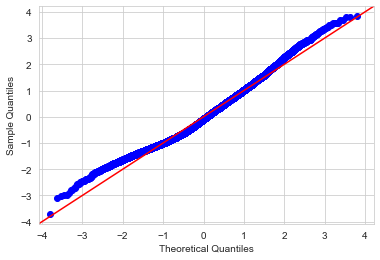

In [43]:
# Residuals do not appear to have any significant deviations, so the normalization for this model appears to be okay.
# Perhaps this is even better than our simple lr model.
import scipy.stats as stats
residuals = model4.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line = '45', fit = 'True')
fig.show()

In [44]:
# Performing an OLS model on sqft_living, view_y_n, and total_dist.
# This model improves r-sqaured from 0.380 to 0.381
model5 = sm.OLS(y_train, sm.add_constant(X_train_full[['sqft_living', 'view_y_n', 'total_dist']])).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     2826.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        20:41:55   Log-Likelihood:            -1.8421e+05
No. Observations:               13790   AIC:                         3.684e+05
Df Residuals:                   13786   BIC:                         3.684e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.782e+05   3922.417     45.431      0.000    1.71e+05    1.86e+05
sqft_living   158.7385      1.839     86.316      0.000     155.134     162.343
view_y_n     9.414e+04   5018.548     18.758      0.000    8.43e+04    1.04e+05
total_dist  -2.664e+05      2e+04    -13.352      0.000   -3.05e+05   -2.27e+05
==============================================================================
Omnibus:                      352.272   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              378.416
Skew:                           0.403   Prob(JB):                     6.73e-83
Kurtosis:                       2.907   Cond. No.                     3.17e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.17e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<ipython-input-45-a8860093bc42>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


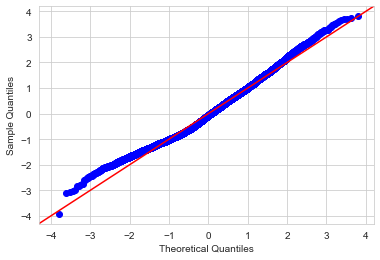

In [45]:
# Residuals do not appear to have any significant deviations, so the normalization for this model appears to be okay.
# Perhaps this is even better than our simple lr model.
import scipy.stats as stats
residuals = model5.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line = '45', fit = 'True')
fig.show()

In [46]:
# Performing an OLS model on sqft_living, view_y_n, total_dist, and bedrooms.
# This model improves r-sqaured from 0.381 to 0.389
model6 = sm.OLS(y_train, sm.add_constant(X_train_full[['sqft_living', 'view_y_n', 'total_dist', 'bedrooms']])).fit()
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     2193.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        20:41:55   Log-Likelihood:            -1.8411e+05
No. Observations:               13790   AIC:                         3.682e+05
Df Residuals:                   13785   BIC:                         3.683e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.343e+05   5685.538     41.208      0.000    2.23e+05    2.45e+05
sqft_living   177.5831      2.296     77.337      0.000     173.082     182.084
view_y_n     8.955e+04   4997.161     17.919      0.000    7.98e+04    9.93e+04
total_dist  -2.883e+05   1.99e+04    -14.497      0.000   -3.27e+05   -2.49e+05
bedrooms    -2.741e+04   2023.026    -13.548      0.000   -3.14e+04   -2.34e+04
==============================================================================
Omnibus:                      357.730   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              385.943
Skew:                           0.410   Prob(JB):                     1.56e-84
Kurtosis:                       2.980   Cond. No.                     3.19e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<ipython-input-47-aa0b0e141f42>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


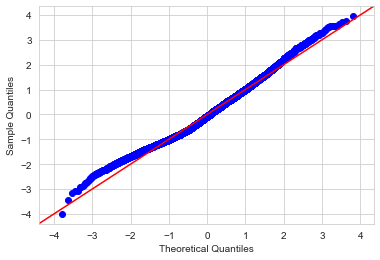

In [47]:
# Residuals do not appear to have any significant deviations, so the normalization for this model appears to be okay.
# Perhaps this is even better than our simple lr model.
import scipy.stats as stats
residuals = model6.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line = '45', fit = 'True')
fig.show()

In [48]:
# Performing an OLS model on sqft_living, view_y_n, total_dist, bedrooms, and bathrooms.
# This model improves r-sqaured from 0.389 to 0.390
model7 = sm.OLS(y_train, sm.add_constant(X_train_full[['sqft_living', 'view_y_n', 'total_dist', 'bedrooms', 'bathrooms']])).fit()
model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     1763.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        20:41:56   Log-Likelihood:            -1.8410e+05
No. Observations:               13790   AIC:                         3.682e+05
Df Residuals:                   13784   BIC:                         3.683e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.259e+05   5909.060     38.231      0.000    2.14e+05    2.37e+05
sqft_living   169.4018      2.791     60.696      0.000     163.931     174.873
view_y_n     9.051e+04   4996.034     18.116      0.000    8.07e+04       1e+05
total_dist   -2.88e+05   1.99e+04    -14.495      0.000   -3.27e+05   -2.49e+05
bedrooms    -2.864e+04   2035.185    -14.070      0.000   -3.26e+04   -2.46e+04
bathrooms     1.39e+04   2701.528      5.147      0.000    8609.154    1.92e+04
==============================================================================
Omnibus:                      375.758   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              406.969
Skew:                           0.421   Prob(JB):                     4.24e-89
Kurtosis:                       2.987   Cond. No.                     3.19e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<ipython-input-49-47cdb75dcb8e>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


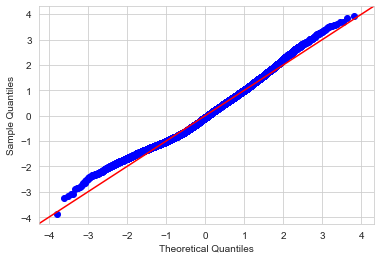

In [49]:
# Residuals do not appear to have any significant deviations, so the normalization for this model appears to be okay.
# Perhaps this is even better than our simple lr model.
import scipy.stats as stats
residuals = model7.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line = '45', fit = 'True')
fig.show()

In [50]:
# Performing an OLS model on sqft_living, view_y_n, total_dist, and sqft_living15.
# This model improves r-sqaured from 0.390 to 0.405
model8 = sm.OLS(y_train, sm.add_constant(X_train_full[['sqft_living', 'view_y_n', 'total_dist', 'sqft_living15']])).fit()
model8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     2348.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        20:41:56   Log-Likelihood:            -1.8393e+05
No. Observations:               13790   AIC:                         3.679e+05
Df Residuals:                   13785   BIC:                         3.679e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.255e+05   4436.413     28.291      0.000    1.17e+05    1.34e+05
sqft_living     114.3697      2.593     44.102      0.000     109.287     119.453
view_y_n       8.188e+04   4945.614     16.556      0.000    7.22e+04    9.16e+04
total_dist    -3.305e+05   1.97e+04    -16.746      0.000   -3.69e+05   -2.92e+05
sqft_living15    76.7891      3.227     23.797      0.000      70.464      83.114
==============================================================================
Omnibus:                      364.371   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              393.138
Skew:                           0.412   Prob(JB):                     4.28e-86
Kurtosis:                       2.932   Cond. No.                     4.41e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<ipython-input-51-54266a897ebb>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


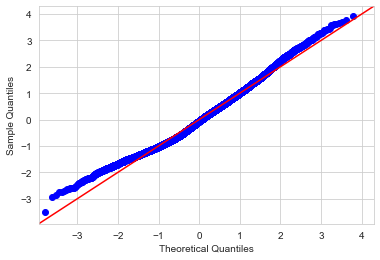

In [51]:
# Residuals do not appear to have any significant deviations, so the normalization for this model appears to be okay.
# Perhaps this is even better than our simple lr model.
import scipy.stats as stats
residuals = model8.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line = '45', fit = 'True')
fig.show()

In [52]:
# Performing an OLS model on sqft_living, view_y_n, total_dist, sqft_living15, sqft_living15, and bedrooms.
# This model improves r-sqaured from 0.405 to 0.412
model9 = sm.OLS(y_train, sm.add_constant(X_train_full[['sqft_living', 'view_y_n', 'total_dist', 'sqft_living15', 'bedrooms']])).fit()
model9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     1931.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        20:41:56   Log-Likelihood:            -1.8385e+05
No. Observations:               13790   AIC:                         3.677e+05
Df Residuals:                   13784   BIC:                         3.678e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           1.78e+05   6082.315     29.262      0.000    1.66e+05     1.9e+05
sqft_living     132.7553      2.967     44.745      0.000     126.940     138.571
view_y_n       7.806e+04   4927.329     15.841      0.000    6.84e+04    8.77e+04
total_dist    -3.486e+05   1.97e+04    -17.714      0.000   -3.87e+05    -3.1e+05
sqft_living15    74.6052      3.213     23.216      0.000      68.306      80.904
bedrooms      -2.491e+04   1987.593    -12.530      0.000   -2.88e+04    -2.1e+04
==============================================================================
Omnibus:                      371.964   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              402.535
Skew:                           0.418   Prob(JB):                     3.90e-88
Kurtosis:                       2.989   Cond. No.                     4.43e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<ipython-input-53-6340876e455d>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


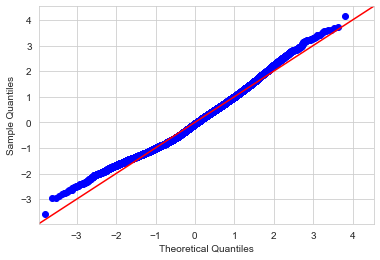

In [53]:
# Residuals do not appear to have any significant deviations, so the normalization for this model appears to be okay.
# Perhaps this is even better than our simple lr model.
import scipy.stats as stats
residuals = model9.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line = '45', fit = 'True')
fig.show()

In [54]:
# Performing an OLS model on sqft_living, view_y_n, total_dist, sqft_living15, sqft_living15, bedrooms, and bathrooms.
# This model improves r-sqaured from 0.412 to 0.413
model10 = sm.OLS(y_train, sm.add_constant(X_train_full[['sqft_living', 'view_y_n', 'total_dist', 'sqft_living15', 'bedrooms', 'bathrooms']])).fit()
model10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     1615.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        20:41:56   Log-Likelihood:            -1.8384e+05
No. Observations:               13790   AIC:                         3.677e+05
Df Residuals:                   13783   BIC:                         3.677e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           1.71e+05   6266.476     27.295      0.000    1.59e+05    1.83e+05
sqft_living     125.9237      3.324     37.886      0.000     119.409     132.439
view_y_n       7.896e+04   4927.799     16.023      0.000    6.93e+04    8.86e+04
total_dist     -3.48e+05   1.97e+04    -17.694      0.000   -3.87e+05   -3.09e+05
sqft_living15    74.1651      3.213     23.086      0.000      67.868      80.462
bedrooms      -2.598e+04   2000.314    -12.990      0.000   -2.99e+04   -2.21e+04
bathrooms      1.206e+04   2652.065      4.547      0.000    6861.717    1.73e+04
==============================================================================
Omnibus:                      379.681   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              411.565
Skew:                           0.423   Prob(JB):                     4.26e-90
Kurtosis:                       2.990   Cond. No.                     4.43e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<ipython-input-55-c2a4f009693b>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


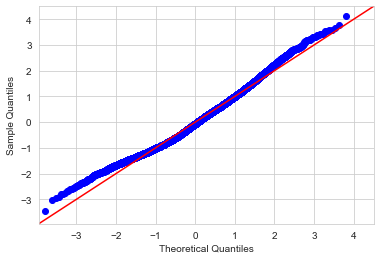

In [55]:
# Residuals do not appear to have any significant deviations, so the normalization for this model appears to be okay.
# Perhaps this is even better than our simple lr model.
import scipy.stats as stats
residuals = model10.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line = '45', fit = 'True')
fig.show()

In [65]:
# Performing an OLS model on sqft_living, view_y_n, total_dist, sqft_living15, sqft_living15, bedrooms, condition_VeryGood.
# This model improves r-sqaured from 0.413 to 0.418
model11 = sm.OLS(y_train, sm.add_constant(X_train_full[['sqft_living', 'view_y_n', 'total_dist', 'sqft_living15', 'bedrooms', 'condition_VeryGood']])).fit()
model11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     1651.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        20:46:37   Log-Likelihood:            -1.8378e+05
No. Observations:               13790   AIC:                         3.676e+05
Df Residuals:                   13783   BIC:                         3.676e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.709e+05   6078.271     28.111      0.000    1.59e+05    1.83e+05
sqft_living          132.2443      2.952     44.805      0.000     126.459     138.030
view_y_n            7.624e+04   4903.532     15.547      0.000    6.66e+04    8.58e+04
total_dist         -3.397e+05   1.96e+04    -17.341      0.000   -3.78e+05   -3.01e+05
sqft_living15         78.1574      3.210     24.350      0.000      71.866      84.449
bedrooms           -2.608e+04   1979.445    -13.177      0.000      -3e+04   -2.22e+04
condition_VeryGood  5.899e+04   4848.324     12.168      0.000    4.95e+04    6.85e+04
==============================================================================
Omnibus:                      359.249   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              387.720
Skew:                           0.411   Prob(JB):                     6.42e-85
Kurtosis:                       2.995   Cond. No.                     4.43e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<ipython-input-66-02e2ca283b2b>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


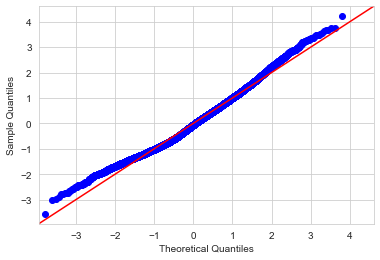

In [66]:
# Residuals do not appear to have any significant deviations, so the normalization for this model appears to be okay.
# Perhaps this is even better than our simple lr model.
import scipy.stats as stats
residuals = model11.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line = '45', fit = 'True')
fig.show()

### 'Final' Model

In the end, you'll arrive at a 'final' model - aka the one you'll use to make your recommendations/conclusions. This likely blends any group work. It might not be the one with the highest scores, but instead might be considered 'final' or 'best' for other reasons.

In [56]:
# code here to show your final model

In [57]:
# code here to evaluate your final model

## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
